# SVD of the flow past a cylinder

In this notebook, we perform a singular value decomposition (SVD) of the flow past a cylinder. The Reynolds number based on the cylinder's diameter $d$, the average inlet velocity $U_m$, and the kinematic viscosity $\nu$ is:

$$
  Re = \frac{U_m d}{\nu} = 100.
$$
The simulation was conducted in OpenFOAM. The simulation domain is shown in the sketch below. All dimensions are given in terms of cylinder diameters.

<img src="figures/cylinder_domain.svg" width=800 />

The goal of this tutorial is to demonstrate:
- how to assemble a data matrix based on a selected subset of a scalar field time series
- how to use the SVD to extract coherent structures in the **vorticity** field
- what noise does to the singular value spectrum
- how automatic rank truncation can help you

## Import of libraries and global settings

In [1]:
import bisect
import torch as pt
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis.svd import SVD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Assembling the data matrix

To create the data matrix, we will:
- investigate the available fields and write times
- create a mask to select a subset of the domain
- load vorticity snapshots and apply the mask; each snapshot forms a column of the data matrix
- subtract the temporal mean

### Inspecting the available data

Exlcuding the initial time, there are 100 snapshots. Execept for the zero folder, all time folders contain pressure, vorticity, surface flux (phi), and velocity.

In [2]:
path = "../../../test/test_data/run/of_cylinder2D_binary/"
loader = FOAMDataloader(path)
times = loader.write_times()
fields = loader.field_names()
print(f"Number of available snapshots: {len(times)}")
print("First five write times: ", times[:5])
print(f"Fields available at t={times[-1]}: ", fields[times[-1]])

Number of available snapshots: 101
First five write times:  ['0', '0.1', '0.2', '0.3', '0.4']
Fields available at t=10:  ['p', 'vorticity', 'phi', 'U']


### Creating a mask

The full computational domain is 22 diameters long to let the vortex shedding develop. For the flow analysis, we will only use the region within $1$ diameter before and $7.5$ diamters after the cylinder's center. The physical diameter in the simulation is $d=0.1m$. Therefore, we create mask selecting the region between $x_{min}=0.1m$ and $x_{max}=0.75$. The $y$-bounds should be large enough to include the entire domain. The $z$-direction is discarded since the simulation is only 2D.

In [3]:
# load vertices and discard z-coordinate
vertices = loader.get_vertices()[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


The mask is a 1D boolean tensor whose elements are `True` if the corresponding vertex is located within the specified bounds. Summing up the mask's elements yields the number of selected vertices (`True` and `False` are cast to 1 and 0, respectively).

In [4]:
print(f"Selected vertices: {mask.sum().item()}/{mask.shape[0]}")

Selected vertices: 7190/13678


We can have a look at the selected vertices using a simple scatter plot. For larger meshes and 3D data, it is more convinient to save the mask in the *flowTorch* HDF5 format and to visualize it in *ParaView* TODO: add reference.

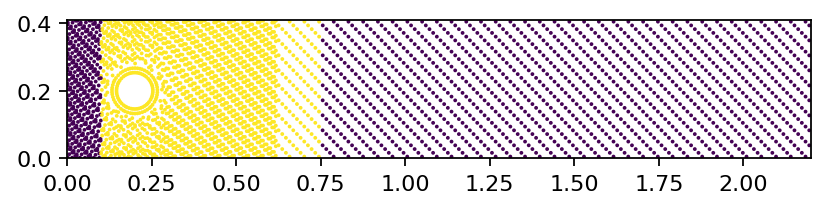

In [5]:
every = 4 # use only every 4th vertex
fig, ax = plt.subplots()
ax.scatter(vertices[::every, 0], vertices[::every, 1], s=0.5, c=mask[::every])
ax.set_aspect("equal", 'box')
ax.set_xlim(0.0, 2.2)
ax.set_ylim(0.0, 0.41)
plt.show()

### Loading the snapshots and extracting the mean

The vortex shedding starts approximately at $t=1.5s$. To build the data matrix, we use all remaining snapshots $t\ge 1.5s$ (86 snapshots). The vorticity is a vectorial field. However, since the simulation is 2D, only the $z$-component contains non-zero entries. Therefore, the resulting data matrix has the dimension **number of selected vertices** x **number of snapshots**.  Since the vortex shedding is fairly periodic, we could also select snapshots within one period as an alternative.

In [6]:
window_times = [time for time in times if float(time) >= 1.5]
data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float32)
for i, time in enumerate(window_times):
    # load the vorticity vector field, take the z-component [:, 2], and apply the mask
    data_matrix[:, i] = pt.masked_select(loader.load_snapshot("vorticity", time)[:, 2], mask)
    
# subtract the temporal mean
data_matrix -= pt.mean(data_matrix, dim=1).unsqueeze(-1)

## Singular value decomposition

In the last part of this tutorial, we compute the SVD of the data matrix and visualize the right/left singular vectors and the singular values. The SVD object automatically performs a so-called rank-truncation (part of the data is discarded). The rank can be prescribed when the SVD object is created. Otherwise, the rank is estimated automatically; see [M. Gavish and D. L. Donoho (2014)](https://ieeexplore.ieee.org/document/6846297) or the *flowTorch* documentation for more information. For now, we use the full rank by setting the rank parameter to a value that is equal or larger than the number of snapshots we used.

In [7]:
svd = SVD(data_matrix, rank=100)

In [8]:
# show some information about the svd
print(svd)

SVD of a 7190x86 data matrix
Selected/optimal rank: 86/86
data type: torch.float32 (4b)
truncated SVD size: 2.3873Mb


### Singular values

The singular values indicate the importance of the corresponding left and right singular vectors in the factorization of the data matrix. It is common practice to plot the relative contribution of each singular value to the full factorization. Another common mean of visualization is the cumulative contribution of the first $n$ singular values to the full data.

In [9]:
s = svd.s
s_sum = s.sum().item()
# relative contribution
s_rel = [s_i / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [s[:n].sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 90 percent
i_90 = bisect.bisect_right(s_cum, 90)

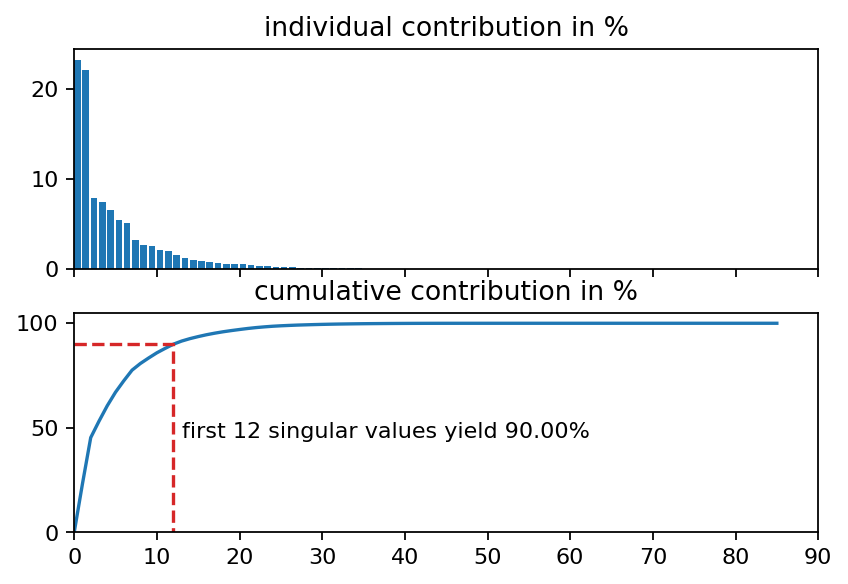

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(s.shape[0]), s_rel, align="edge")
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 105)
ax1.set_title("individual contribution in %")
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_90, i_90], [s_cum[i_90], s_cum[i_90], 0], ls="--", color="C3")
ax2.text(i_90+1, 45, "first {:d} singular values yield {:1.2f}%".format(i_90, s_cum[i_90]))
plt.show()

### Left singular vectors

In the context of proper orthogonal decomposition (POD), the left singular vectors would be called POD modes. Each column of the *U* tensor has the same size as a masked snapshot used to assemble the data matrix. Moreover, the modes are automatically ordered according to the contribution, meaning that the first column/mode is more important than the second one and so on. Since the data is 2D, we can visualize the mode using a **contour plot**. For a cleaner visualization, it is recommendable to use *ParaView* instead.

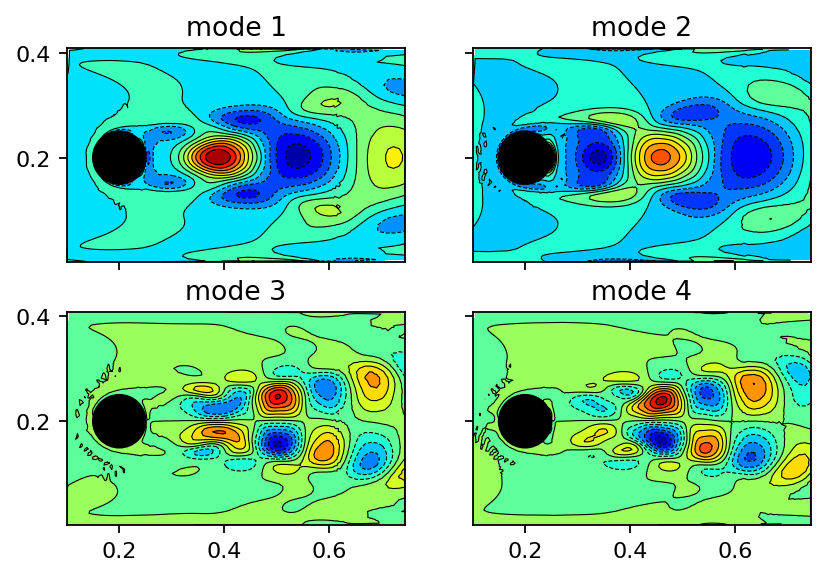

In [11]:
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].tricontourf(x, y, svd.U[:, count], levels=14, cmap="jet")
        axarr[row, col].tricontour(x, y, svd.U[:, count], levels=14, linewidths=0.5, colors='k')
        axarr[row, col].add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
        axarr[row, col].set_aspect("equal", 'box')
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode {count + 1}")
        count += 1
plt.show()

### Right singular vectors

The right singular values reflect the temporal evolution of the corresponding left singular vectors. We can plot each column of the *V* matrix over the snapshot times in the selected time window. Rescaling the left singular vectors with the corresponding singular values yields the so-called POD mode coefficients, which are depicted below. Note that the signals are quite edgy, indicating that sampling frequency of our snapshots was relatively low. The periodicity of the modes could be improved by selecting the time window more carefully.

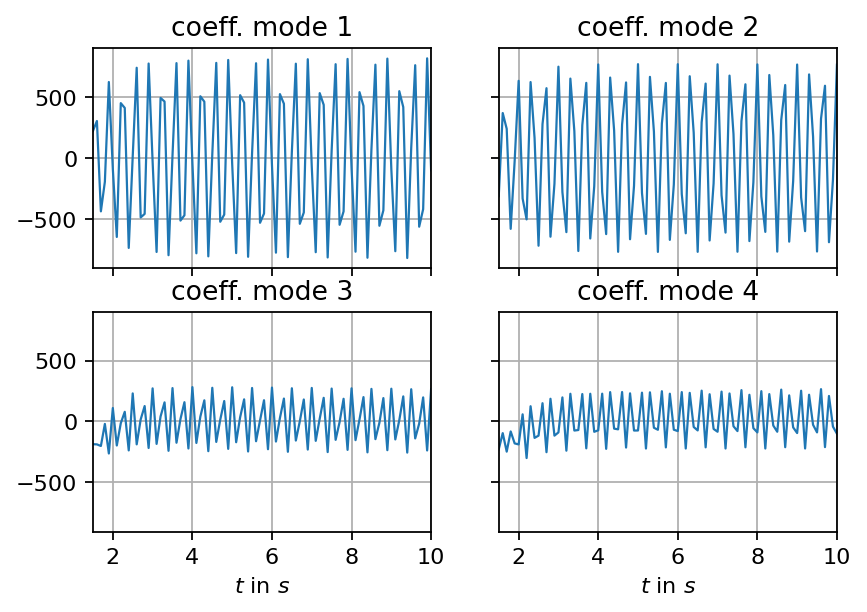

In [12]:
times_num = [float(time) for time in window_times]

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].plot(times_num, svd.V[:, count]*svd.s[count], lw=1, label=f"coeff. mode {i+1}")
        axarr[row, col].set_xlim(min(times_num), max(times_num))
        axarr[row, col].grid()
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"coeff. mode {count + 1}")
        count += 1
for ax in axarr[1, :]:
    ax.set_xlabel(r"$t$ in $s$")
plt.show()